In [102]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv('../results/result.csv')
df = df[df.run >= 3].copy()
df['speed'] = df['sim-cycles'] / df['time']
df['ipc'] = df['instructions'] / df['cycles']
df['MPKI'] = df['cache-misses'] / df['instructions'] * 1000
df

,simulator,benchmark,sim-cycles,run,time,all_data_cache_accesses,cache-misses,cycles,instructions,speed,ipc,MPKI
3,verilator-2,RISCVMini,100000,3,94402,3.064441e+08,9173169.0,8.780217e+08,5.316429e+08,1.059300,0.605501,17.254382
4,verilator-2,RISCVMini,100000,4,93917,3.062446e+08,9163443.0,8.737845e+08,5.324077e+08,1.064770,0.609312,17.211328
5,verilator-2,RISCVMini,100000,5,93916,3.044872e+08,9134529.0,8.743172e+08,5.310073e+08,1.064781,0.607339,17.202266
6,verilator-2,RISCVMini,100000,6,92894,3.051948e+08,9135904.0,8.646072e+08,5.306841e+08,1.076496,0.613786,17.215334
7,verilator-2,RISCVMini,100000,7,105682,3.086422e+08,9184107.0,9.300237e+08,5.389714e+08,0.946235,0.579524,17.040064
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,essent,FMUL,100000,5,4865155,7.860162e+09,486446504.0,2.259654e+10,1.567729e+10,0.020554,0.693792,31.028743
1196,essent,FMUL,100000,6,6135510,7.860328e+09,512084762.0,2.834502e+10,1.567729e+10,0.016299,0.553088,32.664118
1197,essent,FMUL,100000,7,5399135,7.856796e+09,617185115.0,2.451268e+10,1.567729e+10,0.018521,0.639558,39.368108
1198,essent,FMUL,100000,8,5052420,7.858610e+09,502558068.0,2.304154e+10,1.567729e+10,0.019792,0.680392,32.056443


# Speedup

In [104]:
piv = df.pivot_table(values='speed', index='benchmark', columns='simulator')
order = [
  'SHA256',
  'StreamComp',
  'FMUL',
  'FPU',
  'Gemmini',
  'SIGMA',
  'GEMM',
  'Conv2D',
  'RISCVMini',
  'RocketCore',
  'SodorCore'
]
sim_order = [
  'circt-verilator', 'verilator-1', 'verilator-2', 'verilator-4', 'ksim', 'essent', 'repcut-1', 'repcut-2', 'repcut-4', 'repcut-6'
]
baseline_name = 'circt-verilator'
baseline = piv[baseline_name].copy()
for col in piv:
  piv[col] /= baseline

In [105]:
piv = piv.stack().loc[order].reset_index(name='speedup')
piv = piv.set_index('benchmark').reset_index()
def mark_npos(bar, y, *args, **kws):
  npos = []
  for c in bar.containers:
    for child in c.get_children():
      if np.isnan(child.get_height()):
        center = child.get_x() + child.get_width() / 2
        npos.append(center)
  xlim = plt.xlim()
  plt.plot(npos, np.full(len(npos), y), *args, **kws)
  plt.xlim(xlim)

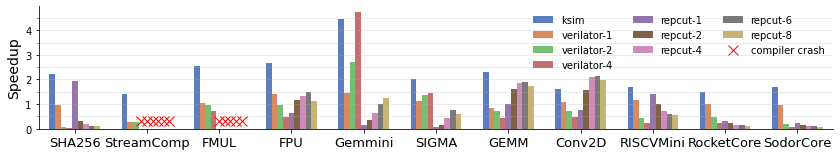

In [110]:
plt.figure(figsize=(12, 2.5))
bar = sns.barplot(
  data=piv,
  x='benchmark', y='speedup',
  hue='simulator', hue_order=['ksim', 'verilator-1', 'verilator-2', 'verilator-4', 'repcut-1', 'repcut-2', 'repcut-4', 'repcut-6', 'repcut-8'],
  palette='muted',
  width=0.7,
)
# set_hatch(bar)
# for c in bar.containers:
#   bar.bar_label(c, fmt='$%.1f$', fontsize=10)
mark_npos(bar, 0.3, 'rx', markersize=10, label='compiler crash')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=3, frameon=False)
# plt.xticks(fontsize=13, rotation=-15, ha='left')
plt.xticks(fontsize=13)
plt.xlabel(None)
# plt.ylim([0, 5])
plt.ylabel('Speedup', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0))
plt.grid(axis='y', alpha=0.3)
plt.grid(axis='y', which='minor', alpha=0.3)
sns.despine()
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.draw()

In [15]:
piv_abs = df.pivot_table(values='speed', columns='simulator', index='benchmark', aggfunc='mean')
baseline_name = 'circt-verilator'
baseline = piv_abs[baseline_name].copy()
piv = piv_abs.apply(lambda x: x / baseline)
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.2f}')

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,
Conv2D,1.00,0.14,1.75,0.76,1.52,1.98,0.19,1.08,0.72,0.48
FMUL,1.00,0.11,2.57,nan,nan,nan,1.63,1.05,0.98,0.73
FPU,1.00,1.00,2.69,0.67,1.10,1.32,0.33,1.52,0.98,0.49
GEMM,1.00,0.24,2.24,0.97,1.48,1.77,0.14,0.79,0.65,0.41
Gemmini,1.00,0.45,4.63,0.18,0.37,0.74,2.12,1.44,2.73,4.95
RISCVMini,1.00,0.39,1.69,1.41,1.00,0.72,0.14,1.15,0.42,0.22
RocketCore,1.00,1.67,1.42,0.34,0.23,0.17,0.30,1.02,0.48,0.23
SHA256,1.00,0.68,2.22,1.91,0.32,0.19,0.03,0.93,0.09,0.03
SIGMA,1.00,0.52,2.02,0.07,0.14,0.44,0.24,1.11,1.36,1.50


# IPC

In [16]:
piv = df.pivot_table(values='ipc', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,
Conv2D,1.804,1.093,3.066,1.779,1.496,0.960,2.293,1.867,0.636,0.269
FMUL,1.884,0.687,2.936,nan,nan,nan,2.599,1.941,0.966,0.417
FPU,3.599,2.583,3.723,1.846,1.540,0.950,2.566,3.124,1.181,0.370
GEMM,1.697,1.708,2.991,2.151,1.354,0.825,2.302,1.326,0.528,0.214
Gemmini,2.865,0.522,3.326,0.528,0.528,0.523,2.234,2.678,2.481,2.249
RISCVMini,2.031,2.508,3.387,2.707,1.238,0.611,2.637,2.207,0.601,0.246
RocketCore,2.338,2.540,2.808,1.499,0.807,0.508,2.478,2.145,0.626,0.225
SHA256,3.319,3.658,4.609,3.394,0.410,0.214,2.634,3.185,0.358,0.156
SIGMA,3.237,1.365,3.533,0.467,0.492,0.756,2.570,3.064,1.963,1.127


# Cycles

In [17]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [18]:
piv = df.pivot_table(values='cycles', columns='simulator', index='benchmark', aggfunc='mean')
# piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,
Conv2D,872.9 M,6.0 G,499.6 M,1.1 G,1.1 G,1.8 G,4.1 G,808.9 M,2.4 G,7.2 G
FMUL,2.5 G,22.8 G,971.3 M,None,None,None,979.0 M,2.4 G,5.1 G,13.6 G
FPU,455.8 M,456.3 M,169.9 M,682.6 M,837.0 M,1.4 G,813.3 M,300.3 M,933.4 M,3.7 G
GEMM,667.4 M,2.7 G,299.2 M,688.8 M,902.3 M,1.6 G,4.3 G,849.7 M,2.1 G,6.5 G
Gemmini,13.0 G,28.7 G,2.8 G,71.1 G,70.7 G,70.3 G,5.6 G,9.0 G,9.5 G,10.5 G
RISCVMini,188.0 M,475.6 M,111.6 M,133.8 M,375.6 M,1.0 G,761.4 M,163.9 M,886.3 M,3.4 G
RocketCore,516.7 M,309.9 M,366.8 M,1.5 G,4.4 G,12.5 G,1.2 G,507.1 M,2.2 G,8.8 G
SHA256,32.6 M,48.1 M,15.4 M,17.6 M,197.7 M,651.5 M,677.9 M,34.7 M,732.4 M,3.9 G
SIGMA,1.5 G,2.9 G,752.0 M,22.9 G,21.4 G,13.8 G,5.8 G,1.4 G,2.2 G,4.0 G


# Instructions

In [19]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [20]:
piv = df.pivot_table(values='instructions', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,
Conv2D,1.6 G,6.6 G,1.5 G,2.0 G,1.7 G,1.7 G,9.5 G,1.5 G,1.5 G,1.9 G
FMUL,4.7 G,15.7 G,2.9 G,None,None,None,2.5 G,4.6 G,4.9 G,5.7 G
FPU,1.6 G,1.2 G,632.4 M,1.3 G,1.3 G,1.3 G,2.1 G,938.1 M,1.1 G,1.4 G
GEMM,1.1 G,4.7 G,892.8 M,1.5 G,1.2 G,1.3 G,10.0 G,1.1 G,1.1 G,1.4 G
Gemmini,37.2 G,15.0 G,9.3 G,37.5 G,37.3 G,36.8 G,12.5 G,24.1 G,23.6 G,23.6 G
RISCVMini,382.0 M,1.2 G,378.1 M,362.1 M,464.9 M,638.8 M,2.0 G,361.6 M,532.5 M,830.2 M
RocketCore,1.2 G,785.4 M,1.0 G,2.2 G,3.5 G,6.4 G,2.9 G,1.1 G,1.3 G,2.0 G
SHA256,108.1 M,173.8 M,70.9 M,59.9 M,81.0 M,139.2 M,1.8 G,110.6 M,262.0 M,611.8 M
SIGMA,4.9 G,4.0 G,2.7 G,10.7 G,10.5 G,10.4 G,14.9 G,4.2 G,4.4 G,4.6 G


# MPKI

In [21]:
piv = df.pivot_table(values='MPKI', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,
Conv2D,0.024,10.347,0.014,0.049,5.761,10.724,4.922,0.022,41.218,78.207
FMUL,0.040,32.983,0.009,nan,nan,nan,0.796,0.012,3.683,12.907
FPU,0.021,0.018,0.031,0.017,2.769,6.350,0.965,0.030,7.443,23.826
GEMM,0.044,8.805,0.027,0.027,12.865,21.663,0.524,0.062,40.082,93.551
Gemmini,14.492,70.087,9.084,47.800,30.510,4.232,1.112,9.675,3.930,4.541
RISCVMini,0.074,0.019,0.051,0.052,6.836,13.508,1.017,0.079,17.159,42.466
RocketCore,0.035,0.052,0.022,0.028,1.695,2.133,0.930,0.034,20.496,52.457
SHA256,0.254,0.117,0.250,0.292,22.810,39.679,1.126,0.251,30.456,67.360
SIGMA,0.012,0.199,0.008,11.153,1.212,1.158,0.255,0.011,3.320,7.961
